In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Attention, Concatenate, Flatten

import matplotlib.pyplot as plt

import datetime

from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load the data
file_path = 'xauusd_d_2000-2024.csv'
data = pd.read_csv(file_path, header=0)

# Convert the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Sort the data by date
data.sort_values(by='Date', inplace=True)

# Reset the index
data.reset_index(drop=True, inplace=True)

# Check for missing values
missing_values = data.isnull().sum()

# Normalization/Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close']])

In [8]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

train_dates = data['Date'][:train_size]
test_dates = data['Date'][train_size:]

In [9]:
# Define and fit the ARIMA model for training data
train_model = ARIMA(train_data[:, 3], order=(5, 1, 0))
train_model_fit = train_model.fit()

# Define and fit the ARIMA model for testing data
test_model = ARIMA(test_data[:, 3], order=(5, 1, 0))
test_model_fit = test_model.fit()

# Make predictions on the test data
predictions = test_model_fit.forecast(steps=len(test_data))

Mean Squared Error (MSE): 356741.59869152
Root Mean Squared Error (RMSE): 597.2784934111725
Mean Absolute Error (MAE): 564.9840510320532


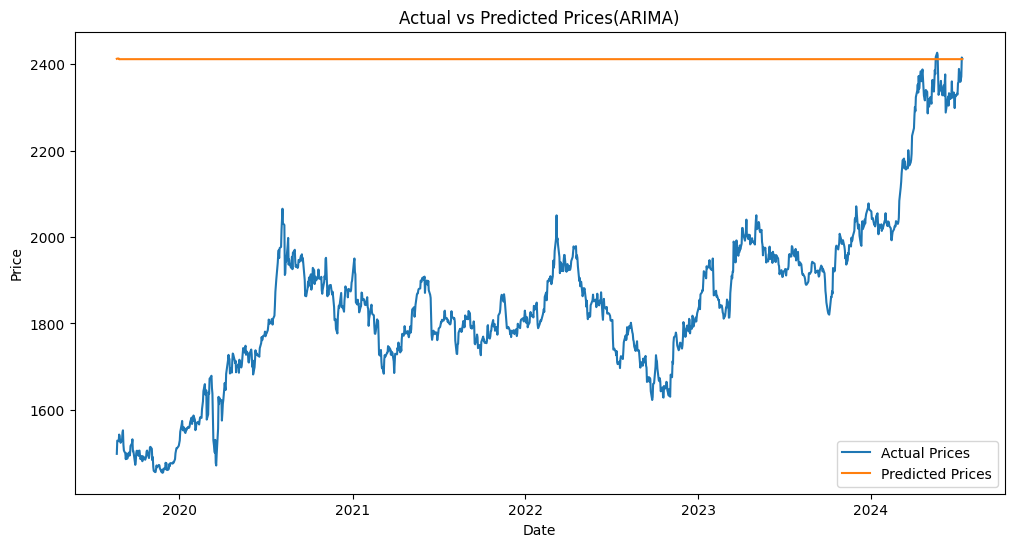

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Inverse scaling to get actual predictions
predictions_actual = scaler.inverse_transform(np.repeat(predictions.reshape(-1, 1), 4, axis=1))[:, 3]

# Calculate performance metrics
mse = mean_squared_error(data['Close'][train_size:], predictions_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['Close'][train_size:], predictions_actual)

# Print performance metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_dates, data['Close'][train_size:], label='Actual Prices')
plt.plot(test_dates, predictions_actual, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices(ARIMA)')
plt.legend()
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4f7kqrx/zmr9fw5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc4f7kqrx/z5uliuvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38551', 'data', 'file=/tmp/tmpc4f7kqrx/zmr9fw5w.json', 'init=/tmp/tmpc4f7kqrx/z5uliuvg.json', 'output', 'file=/tmp/tmpc4f7kqrx/prophet_model4xeuukq4/prophet_model-20240722214529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


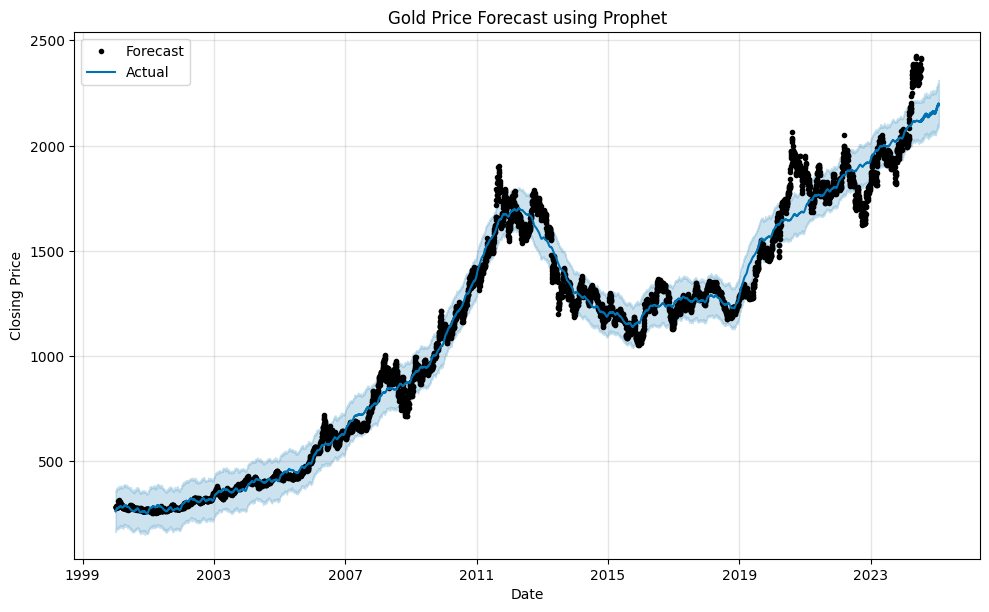

In [6]:
from prophet import Prophet

# Prepare data in the format Prophet expects
df_prophet = pd.DataFrame()
df_prophet['ds'] = data['Date']
df_prophet['y'] = data['Close']

# Create and fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=200)

# Make predictions
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Gold Price Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Forecast', 'Actual'])
plt.show()

In [ ]:
#Reshape data for LSTM (samples, timesteps, features)

timesteps = 365  #Look back at the past 30 days
X_train = []
y_train = []
for i in range(len(train_data) - timesteps):
    X_train.append(train_data[i:i + timesteps])
    y_train.append(train_data[i + timesteps, 3])  # Predict closing price
X_train, y_train = np.array(X_train), np.array(y_train)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer for price prediction

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=2, batch_size=32)

Epoch 1/2
147/147 [==============================] - 56s 350ms/step - loss: 0.0027
Epoch 2/2
147/147 [==============================] - 53s 362ms/step - loss: 1.7134e-04


29/29 [==============================] - 4s 99ms/step
Root Mean Squared Error (RMSE): 63.836002026891975


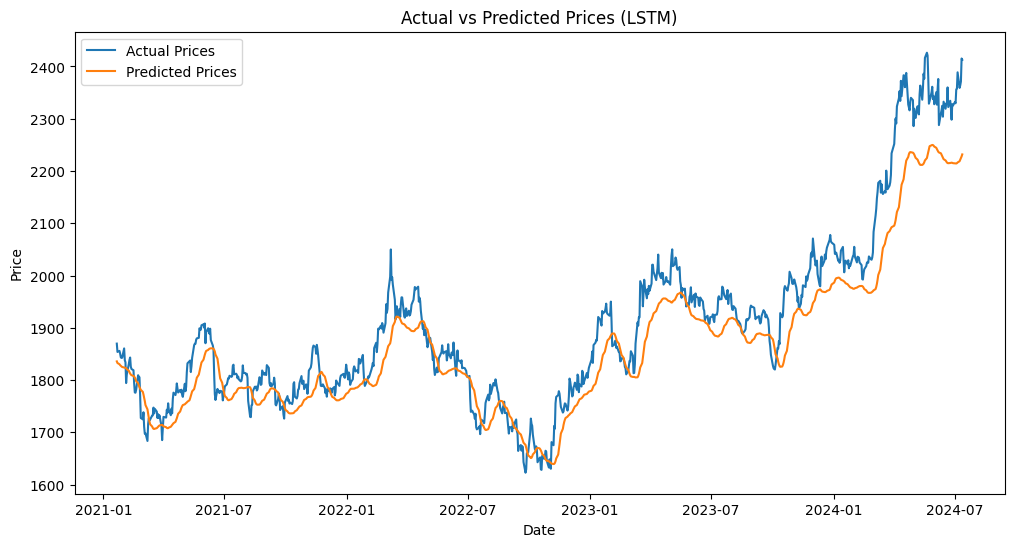

In [ ]:
# Prepare test data in the same format as training data
X_test = []
y_test = []
for i in range(len(test_data) - timesteps):
    X_test.append(test_data[i:i + timesteps])
    y_test.append(test_data[i + timesteps, 3])  # Predict closing price
X_test, y_test = np.array(X_test), np.array(y_test)

# Make predictions on the test data
predictions_scaled = model.predict(X_test)

# Inverse scaling to get actual predictions
predictions_actual = scaler.inverse_transform(np.repeat(predictions_scaled, 4, axis=1))[:, 3]

# Evaluate performance (example: RMSE)
rmse = np.sqrt(mean_squared_error(data['Close'][train_size + timesteps:], predictions_actual))
print('Root Mean Squared Error (RMSE):', rmse)

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_dates[timesteps:], data['Close'][train_size + timesteps:], label='Actual Prices')
plt.plot(test_dates[timesteps:], predictions_actual, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (LSTM)')
plt.legend()
plt.show()

1/1 [==============================] - 0s 47ms/step


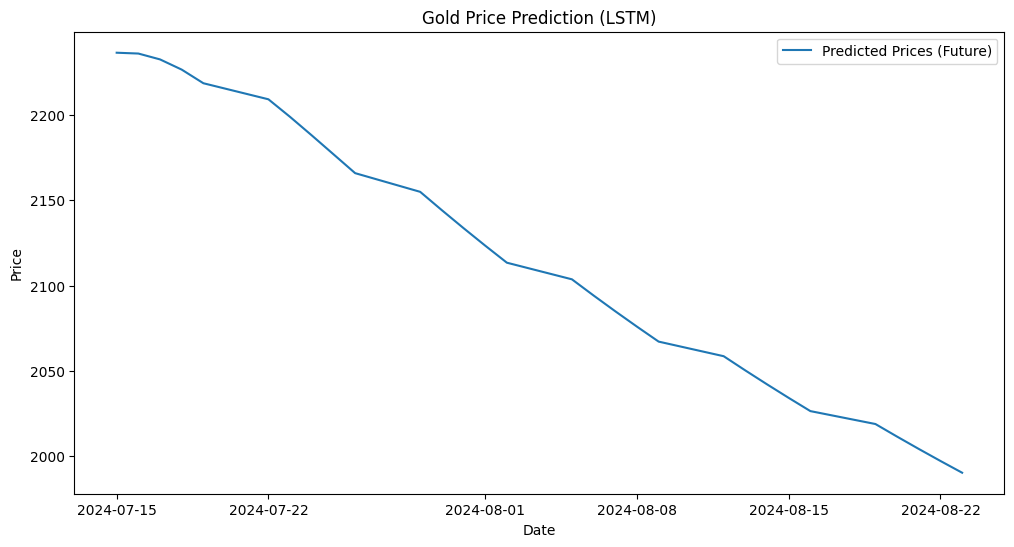

2024-07-15: Predicted Price = 2236.52
2024-07-16: Predicted Price = 2236.04
2024-07-17: Predicted Price = 2232.60
2024-07-18: Predicted Price = 2226.61
2024-07-19: Predicted Price = 2218.62
2024-07-22: Predicted Price = 2209.21
2024-07-23: Predicted Price = 2198.88
2024-07-24: Predicted Price = 2188.03
2024-07-25: Predicted Price = 2176.97
2024-07-26: Predicted Price = 2165.90
2024-07-29: Predicted Price = 2154.94
2024-07-30: Predicted Price = 2144.18
2024-07-31: Predicted Price = 2133.65
2024-08-01: Predicted Price = 2123.39
2024-08-02: Predicted Price = 2113.38
2024-08-05: Predicted Price = 2103.63
2024-08-06: Predicted Price = 2094.14
2024-08-07: Predicted Price = 2084.90
2024-08-08: Predicted Price = 2075.89
2024-08-09: Predicted Price = 2067.11
2024-08-12: Predicted Price = 2058.55
2024-08-13: Predicted Price = 2050.20
2024-08-14: Predicted Price = 2042.05
2024-08-15: Predicted Price = 2034.10
2024-08-16: Predicted Price = 2026.35
2024-08-19: Predicted Price = 2018.78
2024-08-20: 

In [ ]:
last_date = pd.to_datetime('2024-07-12')  # Last recorded date
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=30, freq='B')  # Business days only

# Prepare input data for prediction (last 'timesteps' days of data)
timesteps = 365  # or your actual number of timesteps
last_sequence = test_data[-timesteps:]

future_predictions = []
for _ in range(len(future_dates)):
    # Predict the next day's price
    next_day_prediction_scaled = model.predict(last_sequence.reshape(1, timesteps, 4))

    # Repeat the prediction to match the number of features
    next_day_prediction_scaled_repeated = np.repeat(next_day_prediction_scaled, 4, axis=1)

    # Inverse scaling to get actual prediction
    next_day_prediction_actual = scaler.inverse_transform(next_day_prediction_scaled_repeated)[:, 3]
    future_predictions.append(next_day_prediction_actual[0])

    # Update the last sequence for the next prediction
    next_day_prediction_expanded = np.tile(next_day_prediction_scaled, (1, 4))
    last_sequence = np.concatenate((last_sequence[1:], next_day_prediction_expanded), axis=0)

# Plot predicted prices for the future
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label='Predicted Prices (Future)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Price Prediction (LSTM)')
plt.legend()
plt.show()

# Print predicted prices for the next 20 business days
for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: Predicted Price = {price:.2f}")
